In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

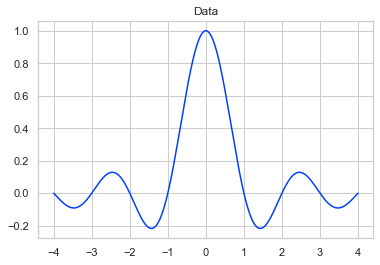

In [67]:
x = np.linspace(-4, 4, 500)
y = np.sinc(x)
plt.title('Data')
plt.plot(x,y)

In [68]:
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [69]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [70]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(n_components=38) 

WEIGHTS - [0.02434626 0.02215133 0.01997898 0.02545278 0.01668499 0.02043995
 0.05327995 0.02419724 0.02047882 0.01973019 0.01888162 0.02275945
 0.03498003 0.02064981 0.02117256 0.0216841  0.02610113 0.05548577
 0.02308202 0.02151331 0.0187741  0.05157196 0.04162074 0.04921135
 0.01792277 0.01797819 0.03629642 0.02347403 0.01806916 0.01996709
 0.01600438 0.02024373 0.01974396 0.01816697 0.02380502 0.01970546
 0.02340898 0.05098542] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.61019057  0.11310726]
 [-2.18671324  0.07909575]
 [ 0.39961859  0.75522367]
 [-3.25285662 -0.06839041]
 [ 1.00819529 -0.00658053]
 [-1.26517734 -0.18343302]
 [ 1.89895711 -0.05253275]
 [ 3.62017579 -0.08055396]
 [-0.38301778  0.77330503]
 [ 1.29843642 -0.19509897]
 [-2.66216683  0.10351652]
 [ 3.43186721 -0.08934298]
 [-3.86757305 -0.0325945 ]
 [-0.94211265  0.06313793]
 [-1.6045653  -0.18599176]
 [-0.05602407  0.99074453]
 [ 2.21706985  0.08834275]
 [ 2.93013904  0.02360419]

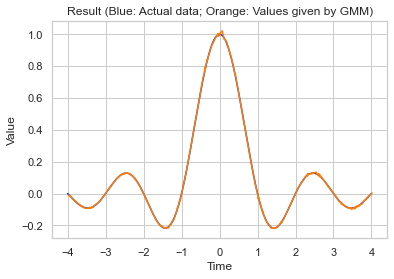

In [138]:
z,_ = best_gmm.sample(500)
plt.title('Result (Blue: Actual data; Orange: Values given by GMM)')
sns.lineplot(signal_3['Time'], signal_3['Value'])
sns.lineplot(z[:,0],z[:,1])
plt.show()

In [139]:
from scipy.stats import wasserstein_distance
wasserstein_distance(signal_3['Value'], z[:, 1])

0.010417049301527216

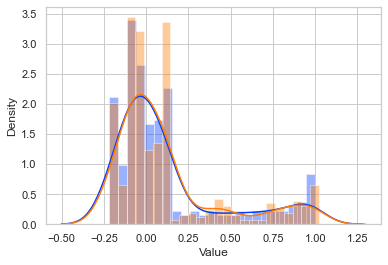

In [140]:
sns.distplot(signal_3['Value'], kde = True)
sns.distplot(z[:, 1], kde = True)
plt.show()

# GMM on FFT of actual time series

In [77]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

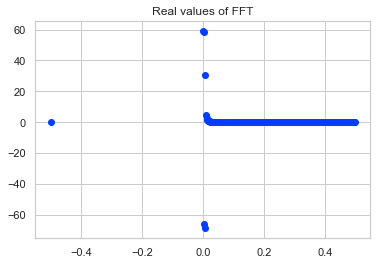

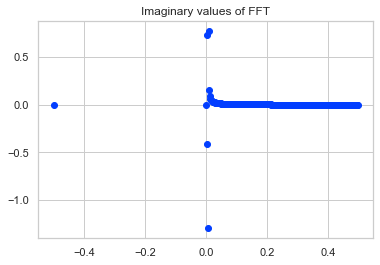

In [78]:
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [79]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [80]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [81]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(n_components=14) 

WEIGHTS - [0.06669686 0.00398406 0.00398406 0.00398406 0.00398406 0.2268369
 0.00398406 0.00398406 0.11049114 0.03229912 0.00398406 0.04812161
 0.48368186 0.00398406] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 7.01465909e-02  4.29166011e-02]
 [ 2.00000000e-03 -6.56913438e+01]
 [ 0.00000000e+00  5.92531343e+01]
 [ 8.00000000e-03  3.08901088e+01]
 [ 1.20000000e-02  2.39713042e+00]
 [ 2.00980094e-01  4.25180905e-03]
 [ 6.00000000e-03 -6.88419501e+01]
 [ 1.00000000e-02  4.87691751e+00]
 [ 1.14792646e-01  1.51115355e-02]
 [ 2.11211690e-02  6.63918072e-01]
 [ 4.00000000e-03  5.82931256e+01]
 [ 4.13068709e-02  1.34331019e-01]
 [ 3.76732883e-01  5.34177998e-04]
 [-5.00000000e-01  0.00000000e+00]] 



In [82]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=8) 

WEIGHTS - [0.54323682 0.09875817 0.00398406 0.04420458 0.00796813 0.29388011
 0.00398406 0.00398406] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.60818054e-01  1.02439437e-03]
 [ 5.42585587e-02  1.30072044e-02]
 [ 6.00000000e-03 -1.29779390e+00]
 [ 1.74396892e-02  5.02472196e-02]
 [ 6.00000000e-03  7.54544099e-01]
 [ 1.55809264e-01  4.19410512e-03]
 [ 2.00000000e-03 -4.12756318e-01]
 [-5.00000000e-01  0.00000000e+00]] 



In [83]:
#Sampling
z1,_ = best_gmm0.sample(251)
z1i,_ = best_gmm0i.sample(251)

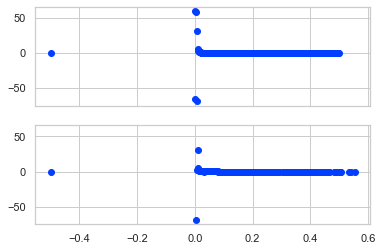

In [84]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

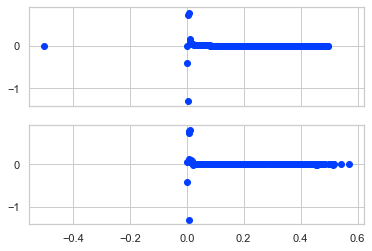

In [85]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [134]:
print('Real: ', wasserstein_distance(freq_ampli3['Ampli'], z1[:, 1]))
print('Imag: ', wasserstein_distance(freq_ampli3i['Ampli'], z1i[:, 1]))

Real:  0.7282434694965841
Imag:  0.011019922217288716


In [87]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [88]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [89]:
f = fftpack.fftfreq(500)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [90]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [91]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [92]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [93]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: 0.0,
 0.002: 0.0,
 0.004: 0.0,
 0.006: -68.84253398103144,
 0.008: 1.971529585259551,
 0.01: 4.8766452544924475,
 0.012: 2.3968040311828283,
 0.014: 0.7704383096426937,
 0.016: 1.010744925837502,
 0.018: 0.0,
 0.02: 0.8208311256873575,
 0.022: 0.4651721470913005,
 0.024: 0.47101205927552114,
 0.026: 0.0,
 0.028: 0.0,
 0.03: 0.20413061470793148,
 0.032: -0.2855449129220058,
 0.034: 0.1947315067145028,
 0.036: 0.0,
 0.038: 0.14527617418514346,
 0.04: 0.15814442503522053,
 0.042: 0.10850766840638375,
 0.044: 0.1183311769697814,
 0.046: 0.09326708205620625,
 0.048: 0.0697362731481026,
 0.05: 0.0,
 0.052: 0.06567567998260715,
 0.054: 0.0,
 0.056: 0.0,
 0.058: 0.0576535343932307,
 0.06: 0.05747925165696395,
 0.062: 0.05073422525594537,
 0.064: 0.0,
 0.066: 0.05228799375133111,
 0.068: 0.0,
 0.07: 0.04271702540314746,
 0.072: 0.039454867857036634,
 0.074: 0.02753970464105005,
 0.076: 0.04018305618081829,
 0.078: 0.0,
 0.08: 0.03270385521462277,
 0.082: 0.024602396971856844,
 0.084: 0.0,

In [94]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.002: -0.35763554731964864j,
 0.004: 0.0,
 0.006: (-68.84253398103144+0.7401574810786986j),
 0.008: (1.971529585259551+0.24835132094329304j),
 0.01: (4.8766452544924475+0.8086248447336853j),
 0.012: (2.3968040311828283+0.13506303114568113j),
 0.014: (0.7704383096426937+0.060249403266877014j),
 0.016: (1.010744925837502+0.14711364562010643j),
 0.018: 0.0512744476012377j,
 0.02: (0.8208311256873575+0.023493799727100233j),
 0.022: 0.4651721470913005,
 0.024: 0.47101205927552114,
 0.026: 0.0,
 0.028: 0.0037939973433602156j,
 0.03: (0.20413061470793148+0.017847907484726033j),
 0.032: (-0.2855449129220058+0.018628558526382545j),
 0.034: (0.1947315067145028+0.02190738083182995j),
 0.036: 0.0,
 0.038: 0.14527617418514346,
 0.04: 0.15814442503522053,
 0.042: (0.10850766840638375+0.03277699304487134j),
 0.044: (0.1183311769697814+0.015834512789629985j),
 0.046: (0.09326708205620625+0.014797688871276393j),
 0.048: (0.0697362731481026+0.014067224080982387j),
 0.05: 0.02219641601039563

In [95]:
value = list(sd.values())

# Final IFFT 

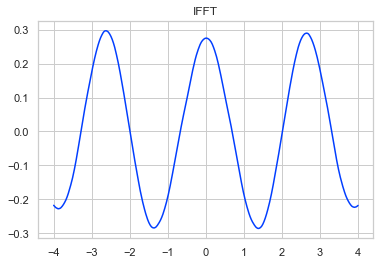

In [96]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(x,ift)

# Log freq

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

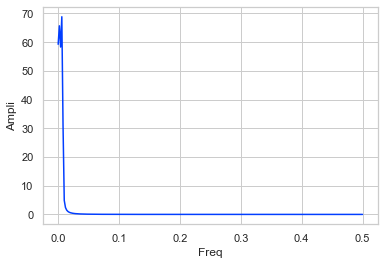

In [97]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return fft_data
freq_ampli = freq(signal_3)
#plt.figure(figsize=(10,6))
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.xlim(-0.1, 0.1)

(250, 2)

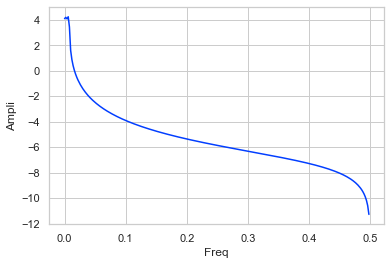

In [98]:
log_ampli = np.log(freq_ampli["Ampli"])
log_freq_ampli= pd.DataFrame(zip(freq_ampli['Freq'],log_ampli),columns=['Freq','Ampli'])
log_freq_ampli = log_freq_ampli.loc[log_freq_ampli['Ampli'] != float('-inf')]
sns.lineplot(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])
np.shape(log_freq_ampli)

In [99]:
dfx = log_freq_ampli
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm2 = gmm

In [100]:
print(best_gmm2, '\n')
print('WEIGHTS -', best_gmm2.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm2.means_, '\n')

GaussianMixture(n_components=13) 

WEIGHTS - [0.09330494 0.02       0.06229643 0.05598351 0.09367028 0.03755667
 0.02509442 0.07016055 0.1029691  0.04130493 0.0794823  0.08284303
 0.23533384] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 1.70129091e-01 -5.00943546e+00]
 [ 4.00000016e-03  3.99902231e+00]
 [ 4.64612854e-01 -8.43733952e+00]
 [ 5.62388960e-02 -2.71193980e+00]
 [ 3.85528348e-01 -7.13449542e+00]
 [ 4.89572461e-01 -9.82560069e+00]
 [ 1.53324742e-02  3.01434073e-01]
 [ 8.77798450e-02 -3.63097229e+00]
 [ 2.19575043e-01 -5.56691906e+00]
 [ 3.19187098e-02 -1.51035615e+00]
 [ 4.29125659e-01 -7.68963060e+00]
 [ 1.26046879e-01 -4.37864974e+00]
 [ 3.03540695e-01 -6.35520615e+00]] 



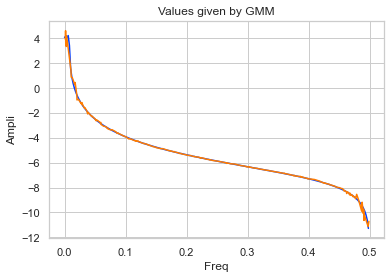

In [101]:
z2,_ = best_gmm2.sample(250)
plt.title('Actual data')
sns.lineplot(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

In [135]:
wasserstein_distance(log_freq_ampli['Ampli'], z2[:, 1])

0.23819288641987674

# Cepstrum

<AxesSubplot:xlabel='Quefrency', ylabel='Cepstrum'>

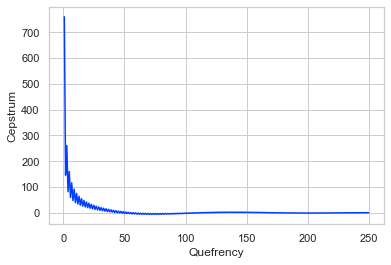

In [103]:
frame_size = signal_3.shape[0]
Fs = 1
dt = 1/Fs
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
y = np.array(signal_3['Value'])
yf = fftpack.fft(y)
yf1 = yf[yf != 0]
quefrency = np.fft.rfftfreq(np.log(yf1).size,freq_vector[1] - freq_vector[0])
cepstrum = np.fft.rfft(np.log(np.abs(yf1)))
cep = pd.DataFrame(zip(quefrency,cepstrum.real),columns=['Quefrency','Cepstrum'])
cep = cep.iloc[1:,:]
sns.lineplot(cep.Quefrency,cep.Cepstrum)

In [104]:
dfx = cep
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [105]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

GaussianMixture(n_components=7) 

WEIGHTS - [0.20543703 0.14622516 0.00401606 0.25521738 0.03211195 0.09995714
 0.25703528] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.24135886e+02 -4.26661469e-01]
 [ 5.29405135e+01  6.91571646e-01]
 [ 1.00200401e+00  7.60045513e+02]
 [ 1.66738061e+02  5.24251205e-01]
 [ 6.32396961e+00  1.22543527e+02]
 [ 2.24649490e+01  2.84380327e+01]
 [ 1.02928960e+02 -1.56691327e+00]] 



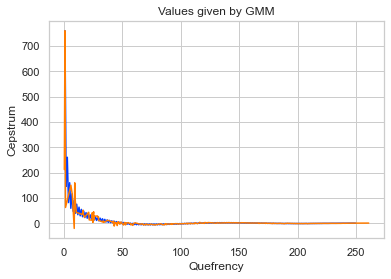

In [136]:
z3,_ = best_gmm3.sample(250)
plt.title('Actual data')
sns.lineplot(cep['Quefrency'], cep['Cepstrum'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z3[:,0],z3[:,1])
plt.show()

In [137]:
wasserstein_distance(cep['Cepstrum'], z3[:, 1])

1.2306723895671936